# Bike rentals analysis

## *(An example of exploratory data analysis and hyper-parameters optimization)*

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

## Part 1 - Data Loading and Environment Preparation

### 1.1 Preparing the virtual environment

*First of all, it is essential to prepare the new virtual environment for solving this task and activate it:*

```sh
virtualenv env_python3_sklearn
. ./env_python3_sklearn/bin/activate
```

*To make it possible to use this environment in the Jupyter notebook, it is necessary to install the IPyKernel library and add this interpreter to the list of available kernels:*


```sh
pip install ipykernel
python -m ipykernel install --user --name env_python3_sklearn --display-name "python with sklearn"
```

*Now, all we need is install the necessary libraries for data processing, visualization, and modeling:*

```sh
pip install scikit-learn
pip install pandas
pip install matplotlib
pip install statsmodels
pip install tqdm
```

*Also, we'll store the list of installed libraries in the 'requirements.txt' file, to keep the reproducibility on other systems:*

```sh
pip freeze > requirements.txt
```

*Now it is possible to import all these libraries to use them in this Jupyter notebook.*

*I will use the 'calendar' library to produce human-readable labels for months and, perhaps, weekday indexes.*

*Sklearn package will be used to split the data into train and test sets, and to train the models.*

*Also, to plot distributions in further work it will be necessary to use the ECDF function. It is possible to find the implementation of such a function in the 'statsmodels' package.*

In [1]:
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils import parallel_backend
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.smoothers_lowess import lowess

### 1.3 Loading the data into Python runtime as Pandas dataframe

In [2]:
daily_data = pd.read_csv('Bike-Sharing-Dataset/day.csv')
print("Preview of the Bike Sharing dataset:") 
display(daily_data) 

Preview of the Bike Sharing dataset:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


### 1.4 Splitting the data into two parts.

*It is essential for data to be in the correct data type to proceed with processing the data. Also, we would like to inspect the columns for consistency, for example containing invalid of missing data*

In [3]:
# Show current data types of the fields
print('Data types of columns, after importing from file:')
display(daily_data.dtypes)

Data types of columns, after importing from file:


instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

*We see, that some of the fields have to be converted to correct data types. For example, 'dteday' is represented as 'object' data type, which means that it is detected to be a string in Pandas. Let's convert it to DateTime data type, which will allow us to be sure, that data is properly sorted in chronological order.*

In [4]:
daily_data['dteday'] = pd.to_datetime(daily_data['dteday'])
daily_data.sort_values(by='dteday', inplace=True)
daily_data.reset_index(drop=True, inplace=True)

*Now it is possible to be safely split the data into the primary part, and secondary, which will contain the last 30 days.
Also, to be sure, that further transformations and data processing on the primary part of the dataset will not affect the original data, it is reasonable to copy it as a new data-table object instead of just linking it to existing data.*

In [5]:
daily_data_primary = daily_data.iloc[:-30].copy()
print('Last 5 rows of primary dataset:')
display(daily_data_primary.tail())

Last 5 rows of primary dataset:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
696,697,2012-11-27,4,1,11,0,2,1,2,0.291667,0.281558,0.786667,0.237562,123,3836,3959
697,698,2012-11-28,4,1,11,0,3,1,1,0.296667,0.289762,0.506250,0.210821,198,5062,5260
698,699,2012-11-29,4,1,11,0,4,1,1,0.280870,0.298422,0.555652,0.115522,243,5080,5323
699,700,2012-11-30,4,1,11,0,5,1,1,0.298333,0.323867,0.649583,0.058471,362,5306,5668
700,701,2012-12-01,4,1,12,0,6,0,2,0.298333,0.316904,0.806667,0.059704,951,4240,5191


In [6]:
daily_data_secondary = daily_data.iloc[-30:].copy()
print('First 5 rows of secondary dataset:')
display(daily_data_secondary.head())

First 5 rows of secondary dataset:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
701,702,2012-12-02,4,1,12,0,0,0,2,0.347500,0.359208,0.823333,0.124379,892,3757,4649
702,703,2012-12-03,4,1,12,0,1,1,1,0.452500,0.455796,0.767500,0.082721,555,5679,6234
703,704,2012-12-04,4,1,12,0,2,1,1,0.475833,0.469054,0.733750,0.174129,551,6055,6606
704,705,2012-12-05,4,1,12,0,3,1,1,0.438333,0.428012,0.485000,0.324021,331,5398,5729
705,706,2012-12-06,4,1,12,0,4,1,1,0.255833,0.258204,0.508750,0.174754,340,5035,5375


 *To make data more human-readable it is also reasonable to use data descriptions, provided in the 'Readme.txt' file to create dictionaries, that can be used to convert normalized, conventional variables to usual ones*

In [7]:
human_readable_dict = {
    'season' : {1:'spring', 2:'summer', 3:'fall', 4:'winter'},
    'yr' : {0: 2011, 1:2012},
    'mnth' : (lambda x: calendar.month_abbr[x]), 
    'holiday' : {0:'not holiday', 1:'holiday'},
    'weekday' : {0:'sun', 1:'mon', 2:'tue', 3:'wed', 4:'thu', 5:'fri', 6:'sat'},
    'workingday' : {0:'weekend or holiday', 1: 'workingday'},
    'weathersit' : { 
        1: 'Clear, Few clouds, Partly cloudy, Partly cloudy',
        2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
        3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
        4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog',
        },
    'temp'  : (lambda x: int(x * 41)),
    'atemp' : (lambda x: int(x * 50)),
    'hum'  : (lambda x: int(x * 100)),
    'windspeed' : (lambda x: int(x * 67))
    }

In [8]:
def human_readable_df(data_frame, transformation_dict):
    converted_data_frame = data_frame.copy()
    for column in converted_data_frame.columns:
        if column in transformation_dict.keys():
            converted_data_frame[column] = converted_data_frame[column].map(transformation_dict[column])
    return converted_data_frame

*Let's preview the top of such human-readable data frame, to get some intuition about how it looks like*

In [9]:
print('Top 5 rows of dataset, converted into human-readable units:')
display(human_readable_df(daily_data.head(), human_readable_dict))

Top 5 rows of dataset, converted into human-readable units:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,spring,2011,Jan,not holiday,sat,weekend or holiday,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",14,18,80,10,331,654,985
1,2,2011-01-02,spring,2011,Jan,not holiday,sun,weekend or holiday,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",14,17,69,16,131,670,801
2,3,2011-01-03,spring,2011,Jan,not holiday,mon,workingday,"Clear, Few clouds, Partly cloudy, Partly cloudy",8,9,43,16,120,1229,1349
3,4,2011-01-04,spring,2011,Jan,not holiday,tue,workingday,"Clear, Few clouds, Partly cloudy, Partly cloudy",8,10,59,10,108,1454,1562
4,5,2011-01-05,spring,2011,Jan,not holiday,wed,workingday,"Clear, Few clouds, Partly cloudy, Partly cloudy",9,11,43,12,82,1518,1600


*First look at the data in human-readable format shows, that the 'season' column looks very suspicious. For example, we see that December is mapped to spring, which is obviously not correct. Let's preview the unique values of month-season pairs, that occur in our dataset:*

In [10]:
print('Correspondence of months and seasons, that occured in dataset:')
display(
    human_readable_df(daily_data[['season','mnth']], human_readable_dict).\
        drop_duplicates().\
        reset_index(drop=True)
)

Correspondence of months and seasons, that occured in dataset:


,season,mnth
0,spring,Jan
1,spring,Feb
2,spring,Mar
3,summer,Mar
4,summer,Apr
5,summer,May
6,summer,Jun
7,fall,Jun
8,fall,Jul
9,fall,Aug


*It seems, that we just have to replace the season mapping dictionary, and rotate the values by one step to the right:*

In [11]:
human_readable_dict['season'] = {1:'winter', 2:'spring', 3:'summer', 4:'fall'}

*Let's preview the month-season pairs of our dataset again, to check that it is correct now:*

In [12]:
print('Correspondence of months and seasons, after correction of the dictionary:')
display(
    human_readable_df(daily_data[['season','mnth']], human_readable_dict).\
        drop_duplicates().\
        reset_index(drop=True)
)

Correspondence of months and seasons, after correction of the dictionary:


,season,mnth
0,winter,Jan
1,winter,Feb
2,winter,Mar
3,spring,Mar
4,spring,Apr
5,spring,May
6,spring,Jun
7,summer,Jun
8,summer,Jul
9,summer,Aug


*Now season mapping in the dataset looks OK.*

**Comments:**

- *The data was split into two parts based on last-30-days criteria. To be sure, that this process is performed correctly, we sorted the data by date column and reset the index.*

- *For visualization purposes we created a function, that allows us to represent data frame in usual human-readable units.*

## Part 2 - Data Processing and Analysis

### 2.1 Checking and cleaning the data

*First of all, it is necessary to check the data for consistency and the presence of invalid values. Let's check if the data table includes some missing values:*

In [13]:
print('Primary dataframe information: data types and presence of missing values:')
display(daily_data_primary.info())

Primary dataframe information: data types and presence of missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     701 non-null    int64         
 1   dteday      701 non-null    datetime64[ns]
 2   season      701 non-null    int64         
 3   yr          701 non-null    int64         
 4   mnth        701 non-null    int64         
 5   holiday     701 non-null    int64         
 6   weekday     701 non-null    int64         
 7   workingday  701 non-null    int64         
 8   weathersit  701 non-null    int64         
 9   temp        701 non-null    float64       
 10  atemp       701 non-null    float64       
 11  hum         701 non-null    float64       
 12  windspeed   701 non-null    float64       
 13  casual      701 non-null    int64         
 14  registered  701 non-null    int64         
 15  

None

*As we see, there are no missing values in the data frame. It is also reasonable to check the ranges of the data in each column, to be sure that there are no invalid data entries in the dataset:*

In [14]:
print('Summary of dataset values by columns:')
display(daily_data_primary.describe())

Summary of dataset values by columns:


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,351.000000,2.479315,0.479315,6.285307,0.028531,3.004280,0.684736,1.385164,0.502732,0.480847,0.625717,0.190534,866.937233,3661.104137,4528.041369
std,202.505555,1.090839,0.499929,3.329294,0.166602,2.003207,0.464953,0.542489,0.182781,0.162584,0.141988,0.076740,693.470674,1553.467783,1939.766889
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,176.000000,2.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.343478,0.348470,0.519167,0.134958,317.000000,2507.000000,3194.000000
50%,351.000000,2.000000,0.000000,6.000000,0.000000,3.000000,1.000000,1.000000,0.514167,0.503146,0.623750,0.182221,738.000000,3656.000000,4541.000000
75%,526.000000,3.000000,1.000000,9.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.613025,0.728750,0.233221,1135.000000,4739.000000,6041.000000
max,701.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


*It seems that there are no obvious invalid (i.e., too large or too small) values in the dataset.*

*It is also necessary to check, that 'cnt' column is correctly corresponding to the sum of 'casual' and 'registered' columns:*

In [15]:
print('Summary checkout that total count is equal to casual + registered rents:')
display(
    (daily_data_primary['cnt'] == daily_data_primary['casual']\
                                  + daily_data_primary['registered']
    ).describe()
)

Summary checkout that total count is equal to casual + registered rents:


count      701
unique       1
top       True
freq       701
dtype: object

*It seems that this column is also correctly calculated in the original dataset.*

### 2.2 Visualising rentals of bikes per day

*Let's visualize the general timeline of daily bike rentals:*

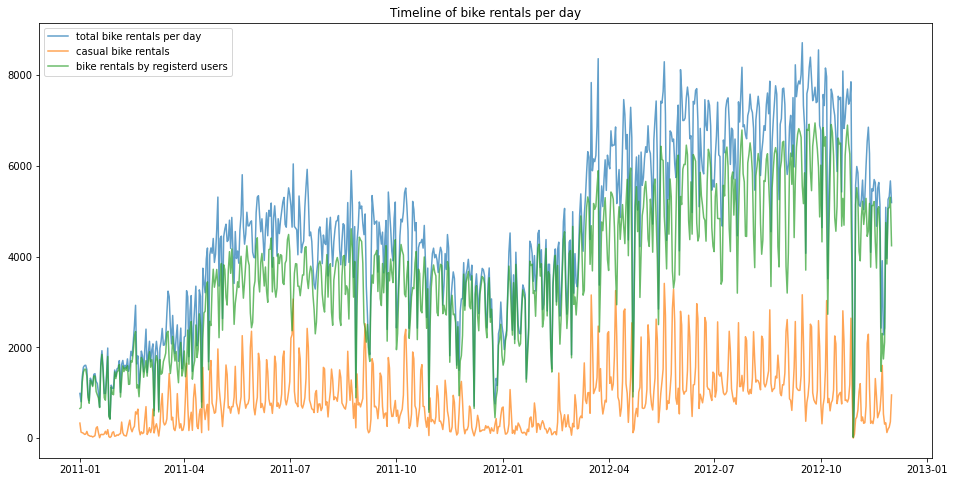

In [16]:
plt.figure(figsize=(16,8))

plt.plot(daily_data_primary['dteday'],
         daily_data_primary['cnt'],
         label='total bike rentals per day',
         alpha=0.7)

plt.plot(daily_data_primary['dteday'],
         daily_data_primary['casual'],
         label='casual bike rentals',
         alpha=0.7)

plt.plot(daily_data_primary['dteday'],
         daily_data_primary['registered'],
         label='bike rentals by registerd users',
         alpha=0.7)

plt.title('Timeline of bike rentals per day')
plt.legend()
plt.show()

### 2.3 Finding the maximum number of bicycles, needed per day

#### 2.3.1 Finding the maximum number of bicycles that was needed in any one day

*It is assumed, that each bicycle can be used exactly no more than in 12 rentals per day. In such conditions, it is possible to define the number of needed bikes on any particular day as `ceil(cnt/12)`. Also, we assume the data type of this new column to be an integer:*

In [17]:
daily_data_primary['bikes_needed'] = (daily_data_primary['cnt'] / 12).apply(np.ceil).astype(np.int64)

In [18]:
print('Preview of data with calculated needed count of bicycles')
display(daily_data_primary.head())

Preview of data with calculated needed count of bicycles


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,bikes_needed
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,83
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,67
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,113
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,131
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,134


#### 2.3.2 Finding the 95% percentile of bicycles that was needed in any one day

In [19]:
nmax = daily_data_primary['bikes_needed'].max()
n95 = int(np.percentile(daily_data_primary['bikes_needed'], 95))
print('Maximal daily amount of bicycles needed:', nmax)
print('95% percentile of total daily counts of bicycle needed:', n95)
print('Proportion of max bikes amount to 95% - percentile: {:.3f}'.format(nmax/n95))

Maximal daily amount of bicycles needed: 727
95% percentile of total daily counts of bicycle needed: 632
Proportion of max bikes amount to 95% - percentile: 1.150


### 2.4 Visualization of the distribution of covered days based on the number of bicycles available

*To build the distribution of covered days based on the number of bicycles, it is necessary to calculate the Empirical Cumulative Distribution Function (ECDF). We will use the library 'statsmodels', that includes necessary classes to build such functions:*

In [20]:
ecdf = ECDF(daily_data_primary['bikes_needed'])

*Now we can predict the number of covered days for each amount of bikes available. For example, we can assume, that number of available bikes can be any from `0` to `nmax`, and divide the range into 100 samples:*

In [21]:
bikes_range = np.linspace(0, nmax, num=100, endpoint=True)
covered_days_percentiles = ecdf(bikes_range)

*Also, we would like to get the distribution in absolute values (number of the days covered) instead of the default relative values, so we have to multiply the distribution function by the total number of days observed in dataset.*

In [22]:
total_days = len(daily_data_primary)
covered_days = covered_days_percentiles * total_days
print('Total days in dataset:',total_days)

Total days in dataset: 701


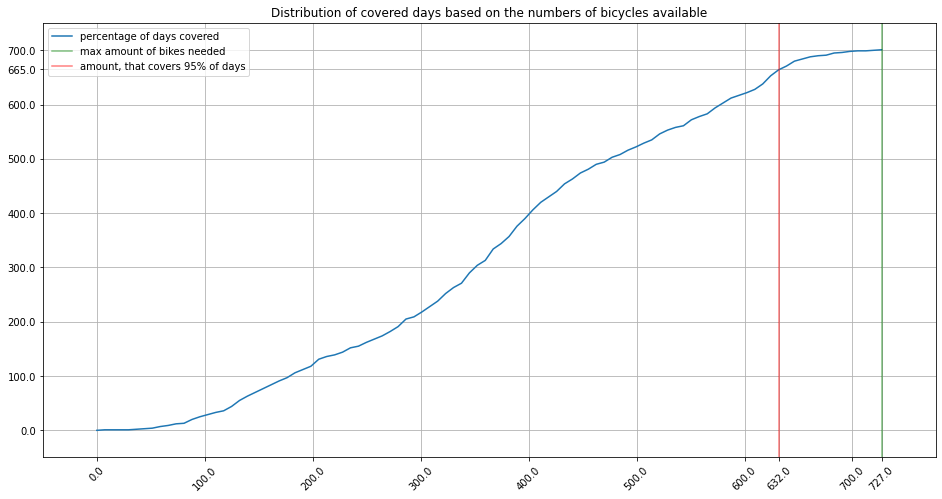

In [23]:
plt.figure(figsize=(16,8))

plt.plot(bikes_range,
         covered_days,
         label='percentage of days covered')

plt.axvline(nmax,
           label = 'max amount of bikes needed',
           c='green',
           alpha=0.5)

plt.axvline(n95,
           label = 'amount, that covers 95% of days',
           c='red',
           alpha=0.5)

locs, labels = plt.xticks()
locs = np.append(locs, [n95, nmax])
plt.xticks(locs, locs, rotation=45)

ylocs, ylabels = plt.yticks()
ylocs = np.append(ylocs, int(total_days * 0.95))
plt.yticks(ylocs, ylocs)


plt.xlim(-50, nmax + 50)
plt.ylim(-50, total_days + 50)
plt.grid()
plt.title('Distribution of covered days based on the numbers of bicycles available')
plt.legend()
plt.show()

**Comments:**

- *It is found, that to cover the 5% of days with the highest demand, it is necessary to keep an additional 15% of bikes in the company's fleet. So, the economic feasibility of the solution to keep these additional bikes has to be researched additionally.*
- *We have to take into account, that demand distribution is not equal during the day, so it's reasonable to perform the same analysis, based on hourly data instead of daily data. It's highly probable, that the max needed amount of bikes to satisfy the peak demand will be significantly higher.*
- *The general timeline of bike rentals per day also shows a clear increasing trend in bike rentals from 2011 to 2013, which is not explained by known data, and can be caused by some unknown or external factors.*

## Part 3 - Building prediction models

### 3.1 Defining a test metric for predicting daily demand

*Predicting daily bike sharing demand is an example of a regression problem. It is quite common to choose one of the next accuracy metrics for such problems:*
- *Mean Absolute Error (**MSE**)*
- *Root Mean Square Error (**RMSE**)*

*However, these absolute values are often not informative enough for the user, because they do not directly explain, how good the model is, and can only be taken into account for comparing the models to each other.*

*To produce more explainable metrics, it is often used the so-called '**R Square**' metric. It measures how much variability of the dependent variable can be explained by the model, and can give the intuition about the necessity of exploration of other factors, that might influence the outcome.*

*R-square is usually not used as the loss function for direct optimization but is useful as the additional metric of model efficiency.*

*To decide which to use between MSE and RMSE metrics, we have to take into consideration, that the RMSE metric is more sensitive to outliers. So, before choosing the proper metric, let's visualize the distribution of our target value `cnt` to get the intuition about how frequent these outliers are.*

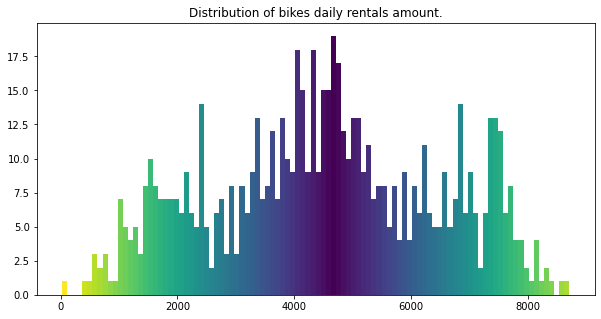

In [24]:
plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(daily_data_primary['cnt'], bins=100)
plt.title('Distribution of bikes daily rentals amount.')

# Now let's paint the bars by their relative distance to modal value
modal_value_index = np.argmax(n)
modal_value_cnt = bins[modal_value_index]
max_residual = max(abs(bins - modal_value_cnt))

for i in range(len(patches)):
    patches[i].set_facecolor(
        plt.cm.viridis(
            abs(bins[i] - modal_value_cnt) / max_residual)
    )

plt.show()

*As we can see here, the outliers are quite common, and can be about two times larger, than the modal value.*

*Also, as we could see earlier, it is more essential for the company to cover most of the days, than to try to keep the fleet of bicycles, that will cover absolutely all cases.*

*So, we will try to use MSE as a loss function this time, to make the model less sensitive to random outliers.*

### 3.2 Building a demand prediction model

*First of all, it is essential to split the dataset into train, validation, and test sets.*

*We will use train and validation sets for fine-tuning and selecting models, and the test set will be used for the final evaluation of the model's performance.*

*It is necessary to keep in mind, that the goal of our model is to predict future data based on past observations.*

*So, to be sure, that there will be no data leaks, caused by such operation (i.e. that future data will not occur in train set), we will split the dataset into a train, validation, and test sets, using chronological order. Therefore, we will build a linear model, based only on the first 60% of chronological data, and then apply the correction to all data.*

*To start modeling, it is necessary to separate the target variable from all other data. Here we will split the data frame into so-called X and Y arrays, which we will use in further steps.*

*It is also essential to examine the data columns and exclude all data, that can lead to data leaks. For example, if we will keep the columns `casual` and `registered`, it will make the model just calculate the `cnt` column from them.*

*Also, keeping, for example, `dteday` and `instant` columns will lead to a model, that is just memorizing the daily rentals, and will give the model no generalization power.*

*The advisability of including `year` column is also questionable, as it will prevent the model from making correct predictions for the next years' data.*

In [25]:
all_columns = daily_data_primary.columns
target_colum = ['cnt']
excluded_columns = ['instant','dteday','yr','casual','registered','bikes_needed']
included_columns = all_columns[~all_columns.isin(excluded_columns + target_colum)]

print('Columns, included to X dataset:')
print(list(included_columns))

X = daily_data_primary[included_columns]
y = np.array(daily_data_primary[target_colum]).ravel()

display(X)

Columns, included to X dataset:
['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900
...,...,...,...,...,...,...,...,...,...,...
696,4,11,0,2,1,2,0.291667,0.281558,0.786667,0.237562
697,4,11,0,3,1,1,0.296667,0.289762,0.506250,0.210821
698,4,11,0,4,1,1,0.280870,0.298422,0.555652,0.115522
699,4,11,0,5,1,1,0.298333,0.323867,0.649583,0.058471


In [26]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

indices_train_val = np.arange(len(y_train_val))

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_val, y_train_val, indices_train_val, test_size=0.25, shuffle=False) 

*As a basis, we will define a random forest model with default hyperparameters. It is also wise to measure the execution time as it will be necessary when we perform hyperparameter tuning and train the model several times.*

In [27]:
%%time
basic_model = RandomForestRegressor(criterion='mae')
basic_model.fit(X_train, y_train)

CPU times: user 550 ms, sys: 206 µs, total: 550 ms
Wall time: 550 ms


RandomForestRegressor(criterion='mae')

*Now, let's calculate the mean absolute error and other metrics for the validation and training sets, which we will use as a baseline for the further model tuning process.*

In [28]:
def calculate_metrics(target, prediction):
    """Calculates MAE, RMSE and R-Square metrics 
    from prediction and groudthruth target data.
    Also, sample standard deviation of groud-truth data,
    to compare errors with."""
    
    return {'sample_std':np.std(target, ddof=1),
            'mae':mean_absolute_error(target, prediction),
            'rmse':mean_squared_error(target, prediction, squared=False),
            'r2_score':r2_score(target, prediction)}

In [29]:
train_metrics = calculate_metrics(basic_model.predict(X_train),y_train)
print('Accuracy metrics for train set:')
display(train_metrics)

Accuracy metrics for train set:


{'sample_std': 1204.4319035870383,
 'mae': 188.36980952380955,
 'rmse': 255.77491640461093,
 'r2_score': 0.954794979697976}

In [30]:
val_metrics = calculate_metrics(basic_model.predict(X_val),y_val)
print('Accuracy metrics for validation set:')
display(val_metrics)

Accuracy metrics for validation set:


{'sample_std': 886.4414628603629,
 'mae': 2043.0293928571427,
 'rmse': 2191.3739207328435,
 'r2_score': -5.1552555670177265}

In [31]:
test_metrics = calculate_metrics(basic_model.predict(X_test),y_test)
print('Accuracy metrics for test set:')
display(test_metrics)

Accuracy metrics for test set:


{'sample_std': 658.0910201710914,
 'mae': 2330.724822695036,
 'rmse': 2451.0929821664317,
 'r2_score': -12.971361196733922}

*As we can see, the Random Forest model with default parameters introduces pretty much of overfitting, which leads to poor performance on the validation set.*

**Comments:**

- *We trained a basic RandomForest model with default hyperparameters and no tuning. The relatively low errors and high R2 score on the train set indicate that it is potentially possible to build a regressor that will predict demand based on the available information on seasonal factors and weather conditions.*
- *However, the low precision metrics on the test set indicate that this model is generally very suitable for the training set.*
- *This is known as a good approach, to build a model that overfits, and then to take some steps to improve its generalizability [2], which we will try to do next.*

## Part 4 - Fine-tuning of one of the models

### 4.1 Finetuning hyperparameters of the model

*I will use the built-in hyperparameter tuning method of the Sklearn package. By default, the available methods for finetuning are grid and random search options. In this case, I will try to use the grid search to find the best combination of hyper-parameters.*

*Let's see what hyper-parameters were used by the baseline model at its default settings:*

In [32]:
basic_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mae',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

*So, it seems, that the most important hyperparameters, that can affect the model's accuracy and generalization power, are:*
- *n_estimators, which refers to the number of trees in the forest*
- *max_depth, which is the maximum depth of the tree*
- *min_samples_split, which is the minimum number of samples required to split an internal node*
- *min_samples_leaf, which defines the minimum number of samples required to be at a leaf node*
- *max_features, which has the influence on the number of features to consider when looking for the best split*

*Also, I will define the optimization criterion as fixed to MAE for all experiments, as it was decided earlier.*

*Another additional parameter, that will be defined in the dictionary, is the maximal possible number of jobs, that will allow us to use all CPU cores to perform experiments and train models.*

*As soon as we have no prior intuition about the best possible options for this particular dataset, it looks reasonable to use logarithmic ranges with base 2 to define the possible values of main hyper-parameters.*

In [33]:
param_grid =  {
    'n_estimators': np.unique(np.logspace(0, 8, num=12, endpoint=True, base=2.0, dtype=int)),
    'criterion':['mae'],
    'max_depth':[None] + list(np.unique(np.logspace(0, 8, num=12, endpoint=True, base=2.0, dtype=int))),
    'min_samples_split': np.unique(np.logspace(0, 6, num=12, endpoint=True, base=2.0, dtype=int)),
    'min_samples_leaf': np.unique(np.logspace(0, 4, num=6, endpoint=True, base=2.0, dtype=int)),
    'max_features':['auto', 'sqrt', 'log2'],
    'n_jobs':[-1]
    }

*Now let's define the Grid Search engine object with our baseline model as the estimator, which performance will be evaluated during the experiments. Our dictionary of ranges will be provided to create possible options to perform experiments.*

In [34]:
staged_model = RandomForestRegressor(criterion='mae')

In [35]:
search = GridSearchCV(staged_model, param_grid, verbose=2, cv=[(idx_train, idx_val)])

In [36]:
search.param_grid

{'n_estimators': array([  1,   2,   4,   7,  12,  20,  34,  56,  93, 154, 256]),
 'criterion': ['mae'],
 'max_depth': [None, 1, 2, 4, 7, 12, 20, 34, 56, 93, 154, 256],
 'min_samples_split': array([ 1,  2,  3,  4,  6,  9, 14, 20, 30, 43, 64]),
 'min_samples_leaf': array([ 1,  3,  5,  9, 16]),
 'max_features': ['auto', 'sqrt', 'log2'],
 'n_jobs': [-1]}

*To perform experiments more efficiently, we will use Sklearn's parallel backend, which will use all available processors to perform a search. Also, we will use the dataset, that includes both train and validation data, as the train-val split is performed internally in each experiment.*

In [37]:
with parallel_backend('loky'):
    search.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 21780 candidates, totalling 21780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4869 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6813 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7906 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9081 tasks      | 

*It is possible now to preview the results of all experiments as the Pandas data frame. In this case, we are interested mostly in top-performing setups with the highest test scores.*

In [38]:
search_result_params = pd.DataFrame(search.cv_results_['params'])
search_results_metrics = pd.DataFrame(search.cv_results_)[['mean_test_score','rank_test_score']]
search_results = pd.concat([search_result_params,search_results_metrics],axis=1)
search_results = search_results.sort_values(by='rank_test_score').reset_index(drop=True)

In [39]:
print('Result table of hyperparameter search experiments. Ranked by test score:')
display(search_results)

Result table of hyperparameter search experiments. Ranked by test score:


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,n_jobs,mean_test_score,rank_test_score
0,mae,93.0,auto,5,3,1,-1,-1.088687,1
1,mae,256.0,sqrt,5,4,1,-1,-1.095628,2
2,mae,4.0,auto,16,43,1,-1,-1.122522,3
3,mae,154.0,auto,5,14,2,-1,-1.126800,4
4,mae,93.0,auto,5,20,1,-1,-1.144730,5
...,...,...,...,...,...,...,...,...,...
21775,mae,93.0,log2,3,1,4,-1,NaN,21776
21776,mae,93.0,log2,3,1,7,-1,NaN,21777
21777,mae,93.0,log2,3,1,12,-1,NaN,21778
21778,mae,93.0,log2,1,1,12,-1,NaN,21779


*To get an intuition about the behavior of model accuracy concerning each of the hyper-parameter values, it is possible to plot the graphs of found dependencies:*

In [40]:
def plot_dependencies(results,
                      exclude_colnames=['mean_test_score','rank_test_score'],
                      target_colname='mean_test_score',
                      figure_size=(10, 5)):
    
    """Plots the dependencies between hyper-parameters and target variables"""
    
    for colname in results.columns:

        if colname not in (exclude_colnames):

            subset = results[[colname, target_colname]]
            subset = subset.dropna()
            subset = subset.sort_values(by=colname)

            x_subset = np.array(subset[colname])
            y_subset = np.array(subset[target_colname])

            values = list(set(x_subset))

            if len(values) > 1:

                plt.figure(figsize=figure_size)
                plt.title(colname)
                plt.scatter(x_subset, y_subset, c='blue', alpha=0.1)

                values.sort()
                maxs = []

                for v in values:
                    v_max = results[results[colname] == v][target_colname].max()
                    maxs.append(v_max)

                plt.plot(values, maxs, c='red', alpha=0.5)

                y_min = np.min(maxs) - 0.1 * abs(np.min(maxs))
                y_max = np.max(maxs) + 0.1 * abs(np.max(maxs))

                plt.ylim(y_min, y_max)

                plt.legend(['max test score', 'mean test score of one experiment'])

                plt.plot()
    plt.show()

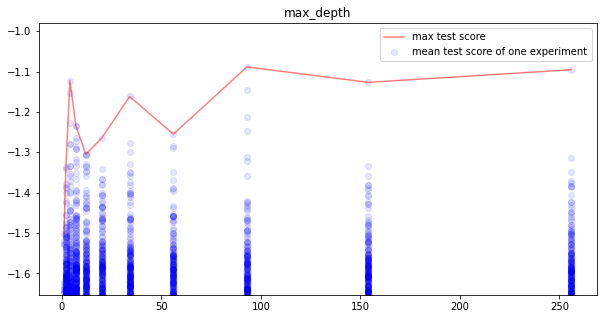

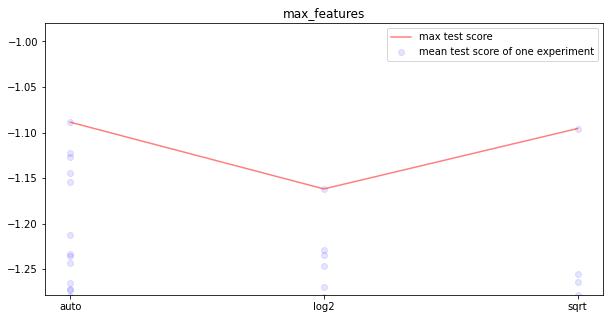

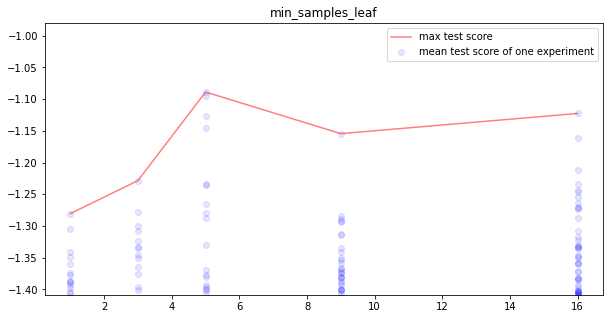

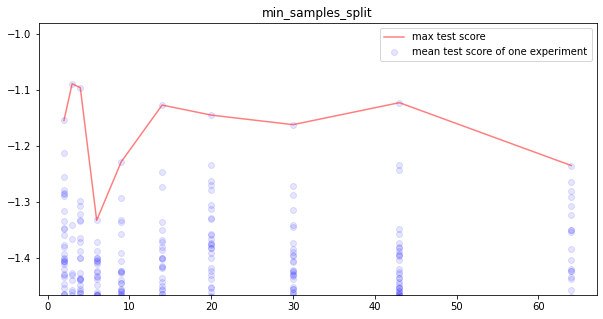

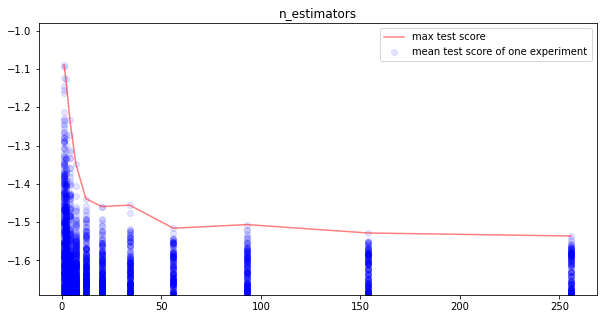

In [41]:
plot_dependencies(search_results)

*It is seen that model, built only based on existing data, performs extremely weak on new data.*

*It may be caused by the general raising trend of bicycle rentals, that is observed in the data.*

*Perhaps, performing correction of the data by dividing it with the value, that is explained by trend itself, cal help model to predict values more correctly.
Let's check this assumption.*

*This time, we will use the 'instant' column as the independent variable for building the linear model, so we have to re-build the dataset for training, keeping this column for further use.*

In [42]:
all_columns = daily_data_primary.columns
target_colum = ['cnt']
excluded_columns = ['dteday','yr','casual','registered','bikes_needed']
included_columns = all_columns[~all_columns.isin(excluded_columns + target_colum)]

print('Columns, included to X dataset:')
print(list(included_columns))

X = daily_data_primary[included_columns].copy()
y = np.array(daily_data_primary[target_colum]).ravel()

Columns, included to X dataset:
['instant', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


In [43]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
indices_train_val = np.arange(len(y_train_val))
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_val, y_train_val, indices_train_val, test_size=0.25, shuffle=False) 

In [44]:
linear_reg = LinearRegression().fit(np.array(X_train['instant']).reshape(-1, 1), y_train)

In [45]:
linear_trend_train = linear_reg.predict(np.array(X_train['instant']).reshape(-1, 1))
trend_train_set = linear_reg.predict(np.array(X_train['instant']).reshape(-1, 1))
trend_trainval_set = linear_reg.predict(np.array(X_train_val['instant']).reshape(-1, 1))
trend_val_set = linear_reg.predict(np.array(X_val['instant']).reshape(-1, 1))
trend_test_set = linear_reg.predict(np.array(X_test['instant']).reshape(-1, 1))

In [46]:
y_train_detrended = y_train / trend_train_set
y_train_val_detrended = y_train_val / trend_trainval_set
y_val_detrended = y_val / trend_val_set
y_test_detrended = y_test / trend_test_set

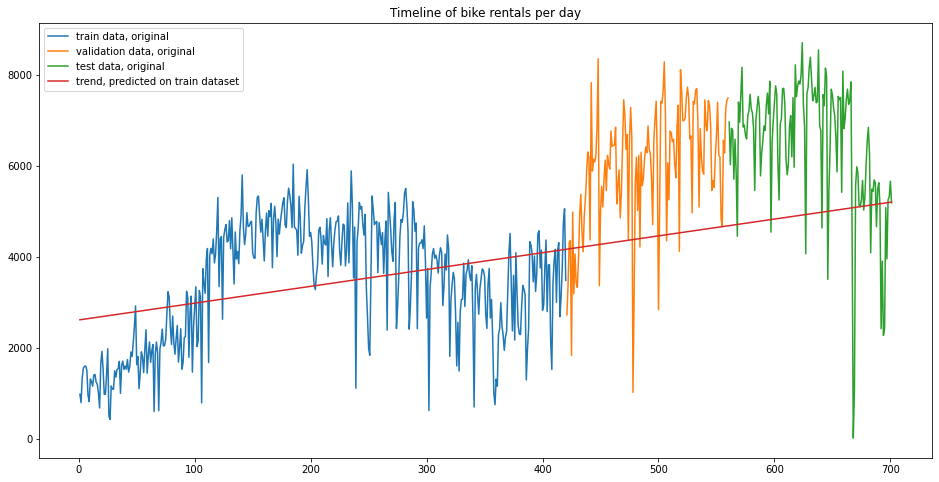

In [47]:
plt.figure(figsize = (16,8))
plt.plot(X_train['instant'],
         y_train,
         label = 'train data, original')
plt.plot(X_val['instant'],
         y_val,
         label = 'validation data, original')
plt.plot(X_test['instant'],
         y_test,
         label = 'test data, original')
plt.plot(X['instant'],
         linear_reg.predict(np.array(X['instant']).reshape(-1, 1)),
         label = 'trend, predicted on train dataset')
plt.legend()
plt.title('Timeline of bike rentals per day')
plt.show()

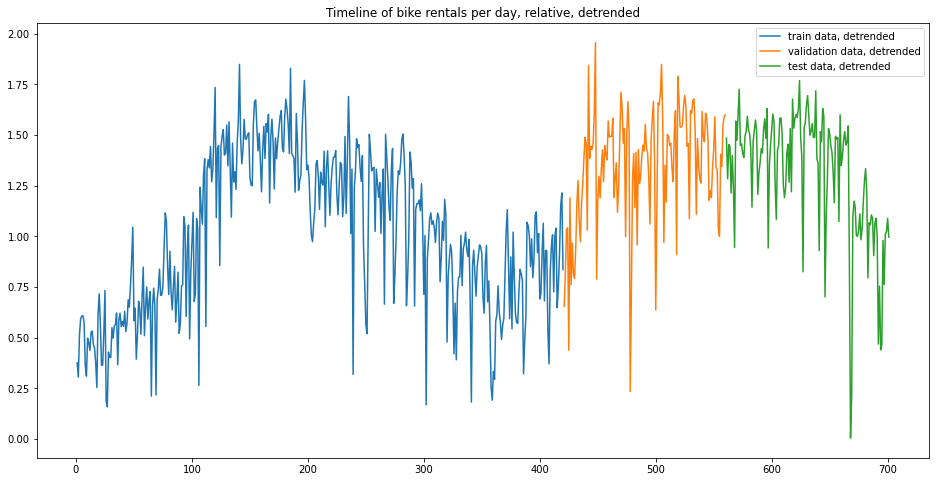

In [48]:
plt.figure(figsize = (16,8))
plt.plot(X_train['instant'],
         y_train_detrended,
         label = 'train data, detrended')
plt.plot(X_val['instant'],
         y_val_detrended,
         label = 'validation data, detrended')
plt.plot(X_test['instant'],
         y_test_detrended,
         label = 'test data, detrended')
plt.legend()
plt.title('Timeline of bike rentals per day, relative, detrended')
plt.show()

*Now, we have to drop the 'instant' column from train, test, and validation data and repeat the hyper-optimization process from the beginning.*

In [49]:
X_train = X_train.drop(columns=['instant'])
X_val = X_val.drop(columns=['instant'])
X_train_val = X_train_val.drop(columns=['instant'])
X_test = X_test.drop(columns=['instant'])

In [50]:
%%time
basic_model_detrended = RandomForestRegressor(criterion='mae')
basic_model_detrended.fit(X_train, y_train_detrended)

CPU times: user 542 ms, sys: 0 ns, total: 542 ms
Wall time: 542 ms


RandomForestRegressor(criterion='mae')

In [51]:
print('Accuracy metrics for train set:',)
display(calculate_metrics(basic_model_detrended.predict(X_train),y_train_detrended))

print('Accuracy metrics for validation set:',)
display(calculate_metrics(basic_model_detrended.predict(X_val),y_val_detrended))

print('Accuracy metrics for test set:',)
display(calculate_metrics(basic_model_detrended.predict(X_test),y_test_detrended))

Accuracy metrics for train set:


{'sample_std': 0.35427403962697945,
 'mae': 0.046071366946890686,
 'rmse': 0.0634252075480761,
 'r2_score': 0.9678722432685879}

Accuracy metrics for validation set:


{'sample_std': 0.2677607570340913,
 'mae': 0.17608862795673852,
 'rmse': 0.23398692128951273,
 'r2_score': 0.23086504840332234}

Accuracy metrics for test set:


{'sample_std': 0.23239557425760918,
 'mae': 0.1808982965037926,
 'rmse': 0.20968817498086773,
 'r2_score': 0.18005777805490486}

*This time, I will use the same train and validation set for hyperparameter tuning also. That said, in all experiments model will be validated on the last 25% of data chronologically.*

In [52]:
param_grid =  {
    'n_estimators': np.unique(np.logspace(0, 8, num=12, endpoint=True, base=2.0, dtype=int)),
    'criterion':['mae'],
    'max_depth':[None] + list(np.unique(np.logspace(0, 8, num=12, endpoint=True, base=2.0, dtype=int))),
    'min_samples_split': np.unique(np.logspace(0, 6, num=12, endpoint=True, base=2.0, dtype=int)),
    'min_samples_leaf': np.unique(np.logspace(0, 4, num=6, endpoint=True, base=2.0, dtype=int)),
    'max_features':['auto', 'sqrt', 'log2'],
    'n_jobs':[-1]
    }

In [53]:
param_grid

{'n_estimators': array([  1,   2,   4,   7,  12,  20,  34,  56,  93, 154, 256]),
 'criterion': ['mae'],
 'max_depth': [None, 1, 2, 4, 7, 12, 20, 34, 56, 93, 154, 256],
 'min_samples_split': array([ 1,  2,  3,  4,  6,  9, 14, 20, 30, 43, 64]),
 'min_samples_leaf': array([ 1,  3,  5,  9, 16]),
 'max_features': ['auto', 'sqrt', 'log2'],
 'n_jobs': [-1]}

In [54]:
staged_model = RandomForestRegressor(criterion='mae')
search_detrended = GridSearchCV(staged_model, param_grid, verbose=2, cv=[(idx_train, idx_val)])
with parallel_backend('loky'):
    search_detrended.fit(X_train_val, y_train_val_detrended)

Fitting 1 folds for each of 21780 candidates, totalling 21780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 1045 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1490 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 2017 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 3313 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4082 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4933 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5864 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6877 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7970 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9145 tasks      |

In [55]:
search_result_params = pd.DataFrame(search_detrended.cv_results_['params'])
search_results_metrics = pd.DataFrame(search_detrended.cv_results_)[['mean_test_score','rank_test_score']]
search_results = pd.concat([search_result_params,search_results_metrics],axis=1)
search_results = search_results.sort_values(by='rank_test_score').reset_index(drop=True)
print('Result table of hyperparameter search experiments after detrending applied. Ranked by test score:')
display(search_results)

Result table of hyperparameter search experiments after detrending applied. Ranked by test score:


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,n_jobs,mean_test_score,rank_test_score
0,mae,154.0,auto,1,14,2,-1,0.440489,1
1,mae,56.0,sqrt,5,2,2,-1,0.435305,2
2,mae,20.0,auto,1,4,7,-1,0.399708,3
3,mae,154.0,auto,3,3,12,-1,0.397505,4
4,mae,12.0,auto,1,4,4,-1,0.385192,5
...,...,...,...,...,...,...,...,...,...
21775,mae,2.0,log2,16,1,256,-1,NaN,21776
21776,mae,2.0,log2,16,1,154,-1,NaN,21777
21777,mae,2.0,log2,16,1,93,-1,NaN,21778
21778,mae,2.0,log2,16,1,34,-1,NaN,21779


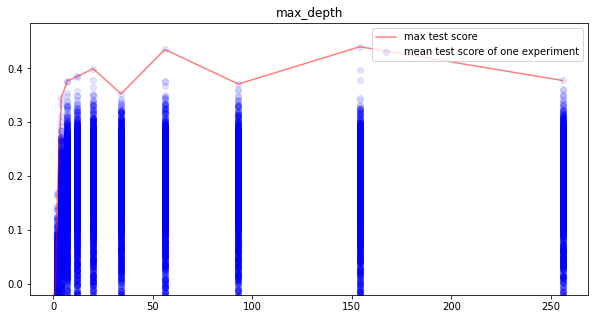

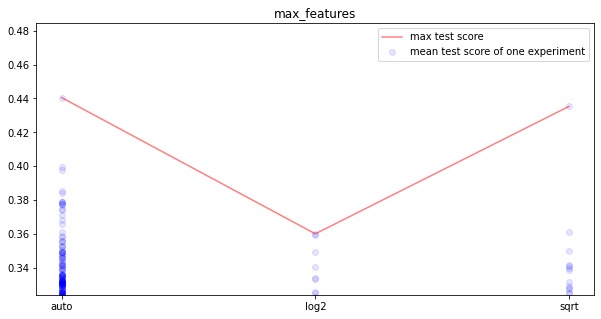

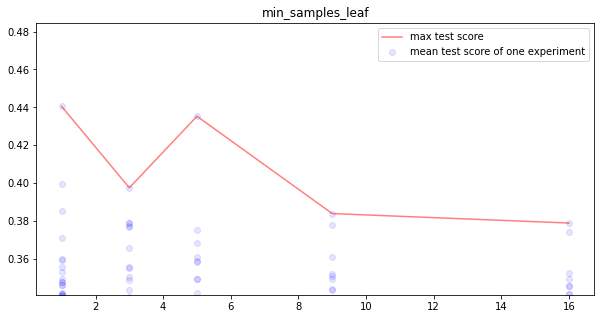

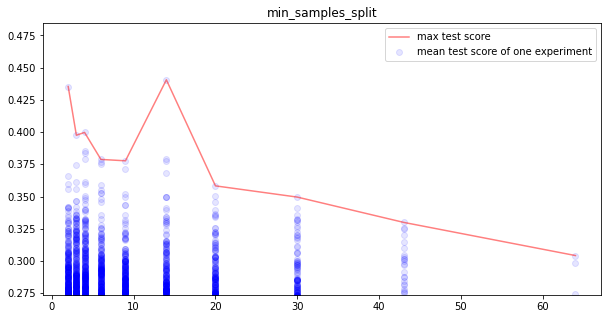

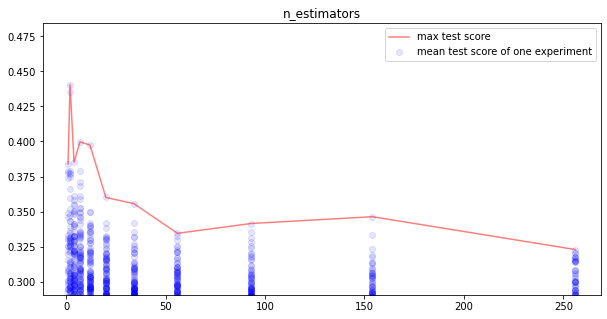

In [56]:
plot_dependencies(search_results)

*It is seen that this time model did the job significantly better.*

*Let's test the best model among all models, trained during optimization, on our test set to decide whether there was any real improvement in its performance.*

In [57]:
print('Best model among all models, trained during optimization:')
print(search_detrended.best_estimator_)

Best model among all models, trained during optimization:
RandomForestRegressor(criterion='mae', max_depth=154, min_samples_split=14,
                      n_estimators=2, n_jobs=-1)


In [58]:
print('Best model performance on train set:')
display(calculate_metrics(search_detrended.best_estimator_.predict(X_train),y_train_detrended))
print('Best model performance on validation set:')
display(calculate_metrics(search_detrended.best_estimator_.predict(X_val),y_val_detrended))
print('Best model performance on test set:')
display(calculate_metrics(search_detrended.best_estimator_.predict(X_test),y_test_detrended))

Best model performance on train set:


{'sample_std': 0.3592140511792472,
 'mae': 0.09798476071077204,
 'rmse': 0.14084676192278944,
 'r2_score': 0.8458929991165148}

Best model performance on validation set:


{'sample_std': 0.2659873974997192,
 'mae': 0.11209009394027734,
 'rmse': 0.1580969969402838,
 'r2_score': 0.6441734448540359}

Best model performance on test set:


{'sample_std': 0.2479005283794067,
 'mae': 0.1878519239189248,
 'rmse': 0.22492817968452944,
 'r2_score': 0.17086755634945316}

*Also, it could be informative to visualize the predictions of this model versus the actual rentals of the test set in absolute values:*

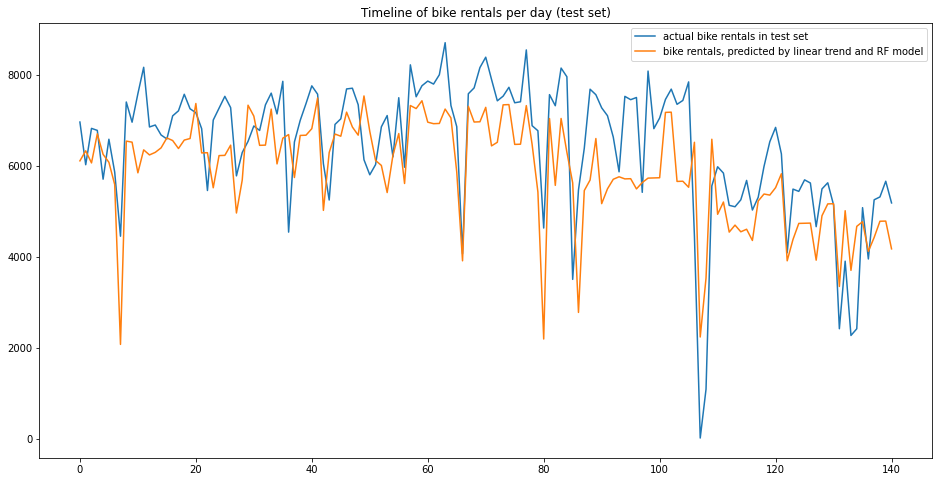

In [59]:
plt.figure(figsize = (16,8))
plt.plot(y_test,
         label = 'actual bike rentals in test set')
plt.plot(search_detrended.best_estimator_.predict(X_test) * trend_test_set,
         label = 'bike rentals, predicted by linear trend and RF model')


plt.plot
plt.legend()
plt.title('Timeline of bike rentals per day (test set)')
plt.show()

In [60]:
print('Best model performance on test set (absolute values):')
display(calculate_metrics(search_detrended.best_estimator_.predict(X_test) * trend_test_set,y_test))

Best model performance on test set (absolute values):


{'sample_std': 1137.3322678345908,
 'mae': 932.3234310449121,
 'rmse': 1118.9371529097239,
 'r2_score': 0.025172563845385687}

*As we can see, the model does good on the validation set, however, is still not so good on the final test set*

*At the same time, we have to be sure that the new model, trained with the same hyper-parameters, will perform the same.*

*We will train the new model with the best-found params and evaluate it in the same conditions:*

In [61]:
tuned_model = RandomForestRegressor(**search_detrended.best_params_)
tuned_model.fit(X_train, y_train_detrended)
print('Tuned model performance on train set:')
display(calculate_metrics(tuned_model.predict(X_train),y_train_detrended))
print('Tuned model performance on validation set:')
display(calculate_metrics(tuned_model.predict(X_val),y_val_detrended))
print('Tuned model performance on test set:')
display(calculate_metrics(tuned_model.predict(X_test),y_test_detrended))

Tuned model performance on train set:


{'sample_std': 0.36746294482783154,
 'mae': 0.09716893337595837,
 'rmse': 0.14356929755554435,
 'r2_score': 0.8469859479158985}

Tuned model performance on validation set:


{'sample_std': 0.31358165221336237,
 'mae': 0.20724011147238963,
 'rmse': 0.28132812956626924,
 'r2_score': 0.18934089489863082}

Tuned model performance on test set:


{'sample_std': 0.2402490401593085,
 'mae': 0.1872812268218788,
 'rmse': 0.22066960374060918,
 'r2_score': 0.15032510845777025}

*It seems that the training process of the Random Forest regression model introduces a lot of instability itself. We can check this assumption by performing several experiments with the same settings on the same set to evaluate the expected variability of performance of such a model.*

In [62]:
repeated_experiment_results = []
for _ in tqdm(range(200)):
    experimental_model = RandomForestRegressor(**search_detrended.best_params_)
    experimental_model.fit(X_train, y_train_detrended)
    experiment_metrics = calculate_metrics(experimental_model.predict(X_val),y_val_detrended)
    repeated_experiment_results.append(experiment_metrics.copy())

100%|██████████| 200/200 [00:46<00:00,  4.35it/s]


In [63]:
repeated_experiment_results_dataframe = pd.DataFrame(repeated_experiment_results)

In [64]:
print('Summary of accuracy metrics of 200 experiments on validation set:')
display(repeated_experiment_results_dataframe.describe())

Summary of accuracy metrics of 200 experiments on validation set:


,sample_std,mae,rmse,r2_score
count,200.000000,200.000000,200.000000,200.000000
mean,0.278806,0.197915,0.262030,0.105657
std,0.014822,0.012835,0.016872,0.103271
min,0.246005,0.167398,0.217525,-0.237131
25%,0.269444,0.189099,0.250384,0.040661
50%,0.280165,0.196078,0.261631,0.107510
75%,0.287374,0.206585,0.273023,0.181678
max,0.317010,0.244492,0.331251,0.312073


**Comments:**

- *It is found that original data includes some general linear trend, that has a high influence on the number of daily rentals.*
- *The influence of this trend was eliminated by dividing the actual rentals count by the predicted average count.*
- *To prevent possible data leaks when training and testing models, the set was divided based on chronological order. This can give us intuition about how the model will behave on unseen future data.*
- *The Random Forest regression model introduces a high level of instability and uncertainty in the training process. Therefore, it is necessary to perform multiple experiments with the same hyperparameters, to be sure that results are reproducible*
- *Even after the hyperparameter tuning process, the model does not explain all the variance of bike rentals number for unseen data. Therefore, it could be reasonable to collect additional data about other valuable factors that could explain the variance of rentals number.*

## Part 5 - Optimise (revenue - cost) by adapting number of bicycles

### 5.1 Determining basic conditions for optimization: revenue

*Let's pick some assumed revenue per rental. For example, we can use sample data from [https://cityridebikerentals.com/bike-rental-pricing], which notes that the approximate city bike rental price starts from around 20 euros. Let's assume that one rental will provide exactly 20 euros of revenue.*

In [65]:
revenue = 20

### 5.2 Determining basic conditions for optimization: costs

*It is not enough data currently to calculate the costs of keeping a fleet of bikes, but let's assume, for example, that keeping one bike for one-day costs around 100 euros per day.*

In [66]:
cost = 100

### 5.3 Determining residuals from test set

*We will define the standard deviation of the future demand based on the RMSE of the best model (on the test set) found in previous steps.*

In [67]:
distribution_std = mean_squared_error(y_test, 
                                      search_detrended.best_estimator_.predict(X_test) * trend_test_set,
                                      squared=False)

print('Distribution STD:',distribution_std)

Distribution STD: 1118.9371529097239


*Expected values will be calculated, based on the predictions of the RF regression model and linear trend, for the existing data of the last 30 days that we kept aside on the first step.*

In [68]:
future_set = daily_data_secondary[included_columns].copy()
future_predicted_trend = linear_reg.predict(np.array(future_set['instant']).reshape(-1, 1))
future_set.drop(columns=['instant'],inplace=True)
future_predicted_sales_detrended = search_detrended.best_estimator_.predict(future_set)
future_predicted_sales = future_predicted_sales_detrended * future_predicted_trend
future_predicted_sales = future_predicted_sales.astype(int)

daily_data_secondary['predicted_cnt'] = future_predicted_sales

print('Dataset for last 30 days, including predicted values:')
display(daily_data_secondary.head())

Dataset for last 30 days, including predicted values:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,predicted_cnt
701,702,2012-12-02,4,1,12,0,0,0,2,0.347500,0.359208,0.823333,0.124379,892,3757,4649,5214
702,703,2012-12-03,4,1,12,0,1,1,1,0.452500,0.455796,0.767500,0.082721,555,5679,6234,5920
703,704,2012-12-04,4,1,12,0,2,1,1,0.475833,0.469054,0.733750,0.174129,551,6055,6606,5925
704,705,2012-12-05,4,1,12,0,3,1,1,0.438333,0.428012,0.485000,0.324021,331,5398,5729,5522
705,706,2012-12-06,4,1,12,0,4,1,1,0.255833,0.258204,0.508750,0.174754,340,5035,5375,4712


In [69]:
print('Distribution mean:',daily_data_secondary['predicted_cnt'].mean())

Distribution mean: 4293.733333333334


### 5.4 Simulating the profit with a fixed number of nmax

*Let's define the function that will perform a simulation test on future data and calculate profit for the given setup:*

In [70]:
def perform_simulation(available_bikes, predicted_demand, revenue, cost, distribution_std):
    
    """Performs one experiment and calculates total profit
    for the given number of available bikes
    and expected distribution of demand"""
    
    residuals_sample = np.random.normal(loc=0.0, 
                                        scale=distribution_std,
                                        size=len(predicted_demand))
    
    demand_sample = np.array(predicted_demand) + residuals_sample
    demand_sample = demand_sample.astype(int)
    demand_sample = np.clip(demand_sample, a_min=0, a_max=None)
    
    total_costs = available_bikes * cost * len(predicted_demand)
    
    possible_rentals = available_bikes * 12
    covered_rentals = np.minimum(demand_sample, possible_rentals)
    total_revenue = np.sum(covered_rentals) * revenue
    
    profit = total_revenue - total_costs
    
    return profit

*Now we can calculate the expected profit in case if we keep the bicycles fleet as large as out previously calculated `nmax` number:*

In [71]:
profit_nmax = perform_simulation(nmax, daily_data_secondary['predicted_cnt'], revenue, cost, distribution_std)
print('Expected total profit with fleet of {} bicycles is {:,.2f} euros'.format(nmax,profit_nmax))

Expected total profit with fleet of 727 bicycles is 517,700.00 euros


In [72]:
def perform_multiple_simulations(n_exp, *args, **kwargs):
    
    """Performs multiple simulations with the same arguments
    to increase sample size of residuals"""
    
    return np.mean([perform_simulation(*args, **kwargs) for _ in range(n_exp)])

*To get more stable results, let's perform, for example, 30 experiments with each size of bicycles fleet. Each time the residuals of predicted demand will be sampled from Gaussian distribution independently.*

*We will use `nmax` as a maximal reasonable size of the bicycle fleet.*

In [73]:
profit_grid = [{'bikes': x, 
                'profit': perform_multiple_simulations(available_bikes = x,
                                                       n_exp = 30,
                                                       predicted_demand = daily_data_secondary['predicted_cnt'],
                                                       revenue = revenue,
                                                       cost = cost,
                                                       distribution_std = distribution_std)}\
                          for x in tqdm(range(nmax))]

100%|██████████| 727/727 [00:00<00:00, 903.42it/s]


*It is reasonable to perform further smoothing of found dependency. We will use the Local weighted smoothing (LOWESS) to calculate the smoothed value of possible profit at each amount of available bicycles.*

In [74]:
profit_df = pd.DataFrame(profit_grid)

In [75]:
smoothed_profit = lowess(profit_df['profit'], profit_df['bikes'], is_sorted=True, frac=0.1, it=0)
profit_df['smoothed_profit'] = smoothed_profit[:,1]

In [76]:
print('Preview of simulations result:')
display(profit_df)

Preview of simulations result:


,bikes,profit,smoothed_profit
0,0,0.000000,186.930076
1,1,4160.000000,4331.148750
2,2,8330.000000,8475.254552
3,3,12456.000000,12619.245230
4,4,16632.666667,16763.119614
...,...,...,...
722,722,412323.333333,409807.070735
723,723,413592.666667,406902.269660
724,724,409295.333333,403997.214757
725,725,420128.666667,401092.046834


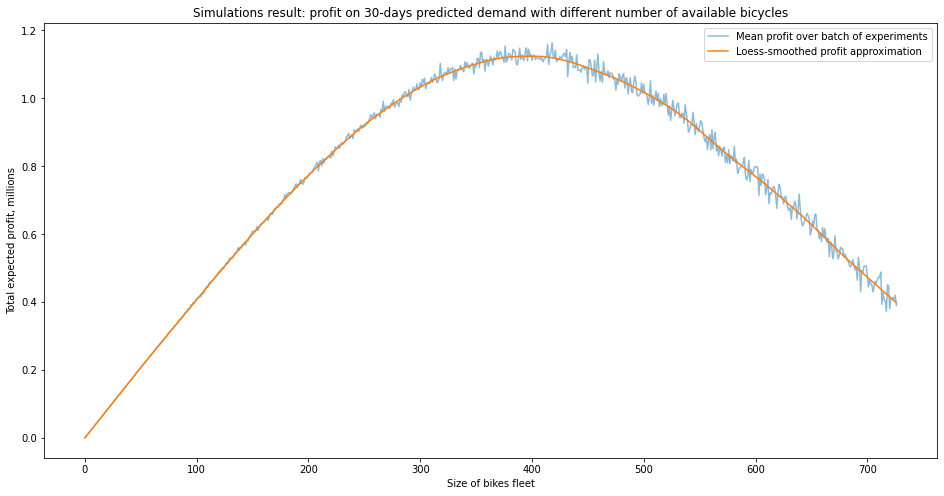

In [77]:
plt.figure(figsize=(16,8))

plt.plot(profit_df['bikes'],
         profit_df['profit'] / 1e6,
         label = 'Mean profit over batch of experiments',
         alpha=0.5)

plt.plot(profit_df['bikes'],
         profit_df['smoothed_profit'] / 1e6,
         label = 'Loess-smoothed profit approximation')

plt.legend()

plt.xlabel('Size of bikes fleet')
plt.ylabel('Total expected profit, millions')
plt.title('Simulations result: profit on 30-days predicted demand with different number of available bicycles')
plt.show()

*So, now we can define the most profitable size of bicycles fleet. We have to take into account both observed values, calculated during simulation, and smoothed approximation, which is more stable to random outliers.*

In [78]:
top_profit = profit_df['profit'].max()
best_n_bikes = profit_df['bikes'][np.argmax(profit_df['profit'])]

top_profit_smoothed = profit_df['smoothed_profit'].max()
best_n_bikes_smoothed = profit_df['bikes'][np.argmax(profit_df['smoothed_profit'])]

print('Top profit based on simulations is {:,.2f} euros, achieved at {} bikes in fleet'.\
      format(top_profit, best_n_bikes))
print('Top profit based on smoothed approximation is {:,.2f} euros, achieved at {} bikes in fleet'.\
      format(top_profit_smoothed, best_n_bikes_smoothed))

Top profit based on simulations is 1,164,056.00 euros, achieved at 418 bikes in fleet
Top profit based on smoothed approximation is 1,124,144.66 euros, achieved at 398 bikes in fleet


**Comments:**

- *Simulation experiments clearly show that there is no need to keep the bicycle fleet, which covers 100% or even 95% of days. However, other factors have to be taken into consideration, such as customer satisfaction, in case if there are always bikes available.*

- *The accuracy of the prediction model has a strong influence on the simulations. If we had a more precise model that can achieve a lower deviation of estimated values from actual, we would get different optimal sizes of bicycle fleet.*

- *It is also necessary to take other seasonal factors into account. Simulation experiments have to be also performed, based on more long-term data that cover different seasons and weather conditions.*

## Part 6 - Reflection / conclusions

- *Building prediction models is an essential part of profit optimization in almost any area.*
- *After performing optimization, it is critical to perform A-B testing of found insights in real-life conditions.*
- *Each simulation is performed under the assumption that the input data does indeed contain all influencing factors. However, this is not always the case. For example, in this data, there are some external influences observed, that lead to, for example, a general upward trend in rentals number.*
- *For more deep and precise data analysis and modeling, it is also necessary to take hourly data into account. It is quite possible, that the assumption, that bike can cover up to 12 customers in days of peak demand, is disproved by the observed fluctuations in demand for bicycles during the day.*
- *The Random Forest regression model itself can be possibly not the best regressor. Generally, Random Forests perform good on classification tasks but tend to suffer from a lack of generalization for regression tasks.*

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

[2] Chollet, F. (2017). Deep Learning with Python . Manning. [https://www.manning.com/books/deep-learning-with-python]